In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf


import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
941,4,NaN,NaN,NaN,90.0,169.0,31.511502,136.0,79.0,0.0,94.0,1.0,106.0,0.886792,1.0,1.0,0.556213,1.0,2.0,0.0,NaN,NaN,NaN,1.0,1.0,8.0,1.0,0.0,8.159320,2.05000,10.209320,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.65,4.45,1.70,0.36,0.09,0.04,66.8,25.6,5.4,1.4,0.6,4.11,12.4,36.2,2.919355,88.1,30.2,34.3,13.5,0.0,297.0,10.9,12.9,32.2,44.661654,0.043434,174.705882,4.722222,2.617647,0.255639,0.013534,140.0,4.10,9.92,NaN,0.75,NaN,21.0,17.0,NaN,168.0,4.34448,0.0,62.0,1.60332,0.0,92.0,2.379120,0.0,128.0,1.44512,0.0,1.483871,2.064516,1.653791,44.721893,52.02432,4.670333,0.314818,NaN,NaN,NaN,NaN,NaN,89.0,NaN,7.58,NaN,1.665728,NaN,0.353474,0.0,NaN,2.39,4.09,16.10,9.0,13.0,6.5,5.6,0.861538,273.0,383.0,1.19,0.342939,0.054338,250.773108,NaN,497.0,NaN,86.0,21.9,5.43,19.80,5.0,NaN,3.06,1.54,400.0,0.002975,0.388889,NaN,NaN,NaN
750,2,NaN,NaN,NaN,66.0,177.0,21.066743,120.0,80.0,0.0,78.0,0.0,87.0,0.896552,1.0,1.0,0.440678,0.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0,NaN,1.0,NaN,3.648064,1.68608,5.334144,NaN,NaN,3.300,2.9000,6.2000,0.0,0.0,0.0,5.00,2.27,1.95,0.56,0.17,0.05,45.4,39.0,11.2,3.4,1.0,4.40,13.6,40.4,2.970588,91.8,30.9,33.7,12.2,0.0,222.0,13.3,10.8,31.1,44.400000,0.048649,113.846154,3.482143,1.164103,0.390000,0.034000,137.0,3.94,9.63,NaN,0.82,NaN,10.0,14.0,0.25,276.0,7.13736,1.0,72.0,1.86192,0.0,204.0,5.275440,1.0,63.0,0.71127,0.0,2.833333,0.875000,0.731906,31.152542,14.22540,4.274927,-0.057992,NaN,NaN,NaN,NaN,36.0,82.0,NaN,8.48,Na

In [3]:
df_igf_cleaned = df.dropna(subset=[IGF])

X_igf, y_igf = df_igf_cleaned.drop(columns=[IGF]), df_igf_cleaned[IGF]
X_train_igf, X_test_igf, y_train_igf, y_test_igf = train_test_split(X_igf, y_igf, test_size=0.2, random_state=42)

## Models exploration

In [8]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]

#  TODO: maybe add DropHighMissingColumns

continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    # 'custom_ohe_no_imputing': Pipeline([('one_hot_encoder', CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True))]),
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}


scores_df = explore_all_variations_of_preprocessing(X_train_igf, y_train_igf, IGF, models, continuous_preprocessings, categorical_preprocessings)

1/48 DecisionTreeRegressor(max_depth=7, random_state=42) PT_iterative_basic original_ohe_no_imputing [-71.42146125 -86.52416007 -77.06086085 -77.6960309  -65.22213995
 -87.3326502  -58.35277079 -83.03002733 -70.28025084 -77.09305163
 -76.95734161 -82.85818702 -77.50083197 -83.84546095 -72.13991723] 76.48767617250061
2/48 Lasso() PT_iterative_basic original_ohe_no_imputing [-62.52149945 -63.48342818 -65.85754222 -60.98206036 -65.31404261
 -66.81839919 -56.15943523 -59.29320659 -58.85662724 -56.92910083
 -60.70163767 -59.81683253 -65.05162081 -67.81602926 -57.19351234] 61.78633163531215
3/48 Ridge() PT_iterative_basic original_ohe_no_imputing [-73.49539945 -70.89918795 -74.99311633 -74.08460496 -92.25250736
 -75.27847961 -71.95463176 -67.30198561 -77.03922909 -64.10302008
 -63.02234735 -72.16719286 -77.2903278  -79.02278674 -65.2463899 ] 73.21008045694856
4/48 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-60.39617647 -61.23796961 -60.18129802 -64.40479901 -58.3295

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.487676
1,PT_iterative_basic,original_ohe_no_imputing,Lasso(),61.786332
2,PT_iterative_basic,original_ohe_no_imputing,Ridge(),73.210080
3,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),59.844091
4,PT_iterative_basic,original_ohe_+_impute_knn,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.877851
5,PT_iterative_basic,original_ohe_+_impute_knn,Lasso(),61.622067
6,PT_iterative_basic,original_ohe_+_impute_knn,Ridge(),72.232321
7,PT_iterative_basic,original_ohe_+_impute_knn,RandomForestRegressor(),59.914922
8,PT_iterative_basic,original_ohe_+_impute_rf,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.664880
9,PT_iterative_basic,original_ohe_+_impute_rf,Lasso(),61.508069


In [12]:
scores_df = _

In [18]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    68.565143
                          original_ohe_+_impute_rf     68.069553
                          original_ohe_no_imputing     68.015265
PT_iterative_basic        original_ohe_+_impute_knn    67.661790
                          original_ohe_+_impute_rf     67.407574
                          original_ohe_no_imputing     67.832045
RS_KNN                    original_ohe_+_impute_knn    67.762641
                          original_ohe_+_impute_rf     67.329345
                          original_ohe_no_imputing     67.658700
RS_iterative_basic        original_ohe_+_impute_knn    67.396318
                          original_ohe_+_impute_rf     67.399054
                          original_ohe_no_imputing     68.233051
Name: MAE, dtype: float64

In [19]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                68.216654
PT_iterative_basic    67.633803
RS_KNN                67.583562
RS_iterative_basic    67.676141
Name: MAE, dtype: float64

In [20]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    67.846473
original_ohe_+_impute_rf     67.551382
original_ohe_no_imputing     67.934765
Name: MAE, dtype: float64

Best combo: RS_KNN + original_ohe_+_impute_rf 

In [5]:
continuous_preprocessor = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

### Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 5 candidates, totalling 75 fits


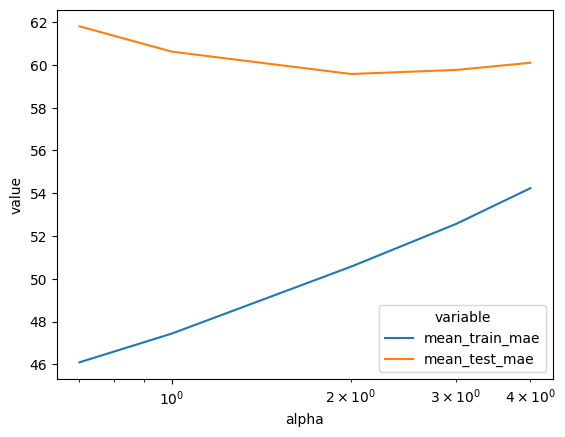

,alpha,mean_train_mae,mean_test_mae
0,0.7,46.092146,61.801020
1,1,47.434576,60.618920
2,2,50.565104,59.572373
3,3,52.560126,59.761605
4,4,54.232004,60.096404


In [21]:
param_grid_lasso = {
    'model__alpha': [0.7, 1, 2, 3, 4],
}

lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Lasso(), continuous_preprocessor, categorical_preprocessor, param_grid_lasso, main_parameter='alpha')
lasso_model_hyperparam_tuning_df

### Ridge

Fitting 15 folds for each of 7 candidates, totalling 105 fits


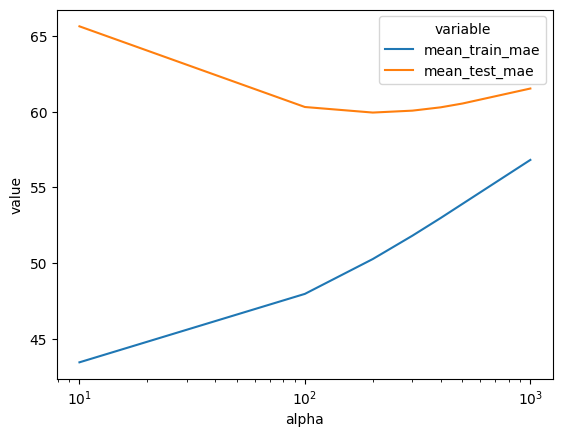

,alpha,mean_train_mae,mean_test_mae
0,10,43.439327,65.641169
1,100,47.962233,60.309706
2,200,50.263287,59.942570
3,300,51.809771,60.069789
4,400,52.974829,60.288631
5,500,53.910038,60.540594
6,1000,56.814594,61.531258


In [23]:
param_grid_ridge = {
    "model__alpha": [10, 100, 200, 300, 400, 500, 1000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Ridge(), continuous_preprocessor, categorical_preprocessor, param_grid_ridge, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

### RandomForest

In [30]:
param_grid_rf = {
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [8, 10, 12],
    'model__min_samples_leaf': [3, 5, 7],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


,params,mean_train_mae,mean_test_mae
16,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 200}",41.810143,60.099159
9,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 200}",31.832130,60.177599
1,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}",33.928776,60.182291
10,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}",33.874325,60.235325
3,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 8, 'model__n_estimators': 200}",37.041478,60.241482
4,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}",36.968499,60.250744
6,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 8, 'model__n_estimators': 200}",41.863576,60.289191
13,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}",36.979434,60.297108
14,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}",38.359807,60.302342
5,"{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}",38.378933,60.303784


In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=13)

tuned_df = compare_random_states(X_train_igf, y_train_igf, rf_model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:22<00:00,  5.68s/it]


,cv_mae
56,-60.252833
24,-60.319136
71,-60.389253
67,-60.390057
8,-60.415431


### DecisionTreeRegressor

In [10]:
param_grid_tree = {
    "model__criterion": ["squared_error", "absolute_error"],
    "model__max_depth": [5, 7, 10, 15],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 20, 25, 30],
    "model__min_samples_leaf": [10, 15, 20, 25],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_tree)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


,params,mean_train_mae,mean_test_mae
60,"{'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",57.744918,64.820633
12,"{'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",57.560372,64.921653
124,"{'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",56.128836,65.008289
126,"{'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}",56.347978,65.039668
70,"{'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 25, 'model__splitter': 'random'}",54.164183,65.175315
105,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 20, 'model__splitter': 'random'}",54.071129,65.201847
14,"{'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}",58.028373,65.317146
106,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}",54.157504,65.367604
63,"{'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 30, 'model__splitter': 'random'}",57.440324,65.409121
13,"{'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}",58.314826,65.413862


In [12]:
model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random')
	
tuned_df = compare_random_states(X_train_igf, y_train_igf, model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [00:42<00:00,  2.31it/s]


,cv_mae
16,-63.625855
45,-63.926099
81,-64.088162
88,-64.180902
73,-64.462722


## Best models - IGF

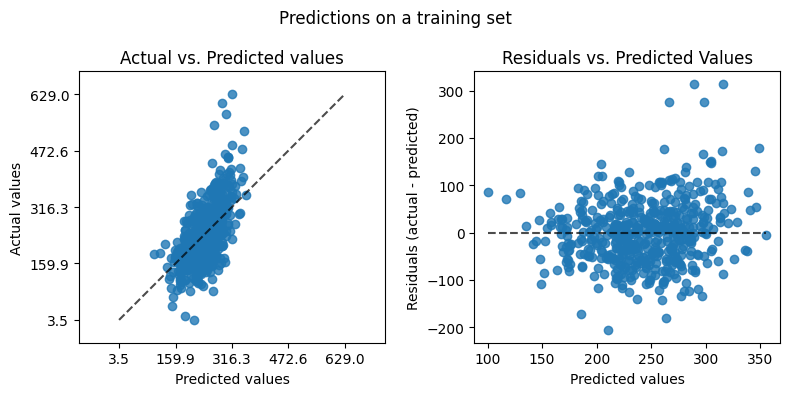

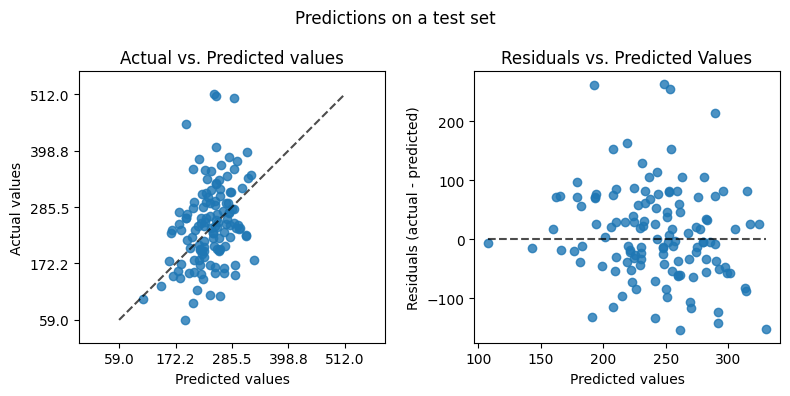

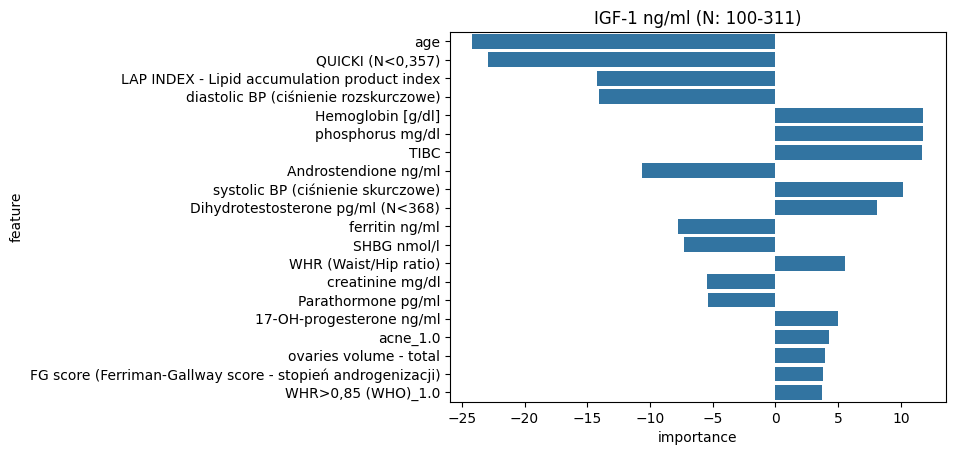

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=2),training,4543.573,51.844,67.406,0.378
1,Lasso(alpha=2),test,6407.883,61.183,80.049,0.075


In [27]:
lasso_model = Lasso(alpha=2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

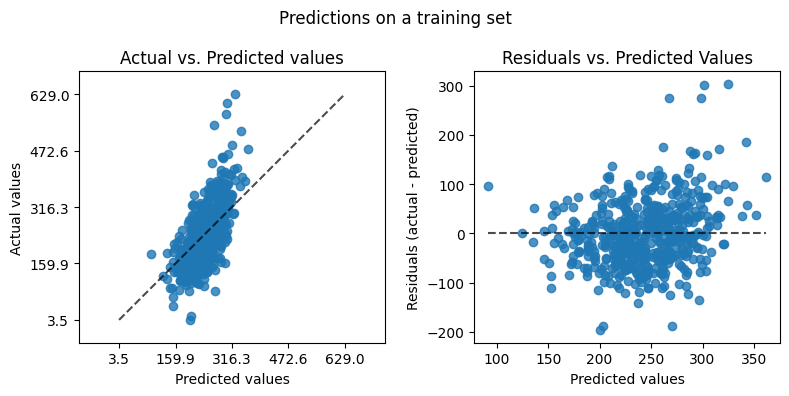

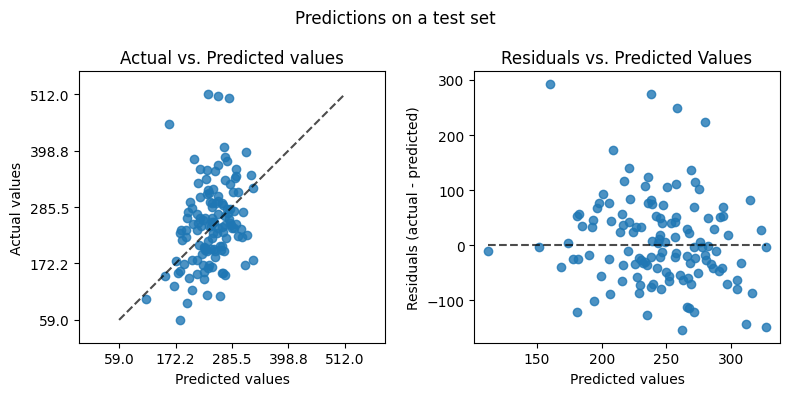

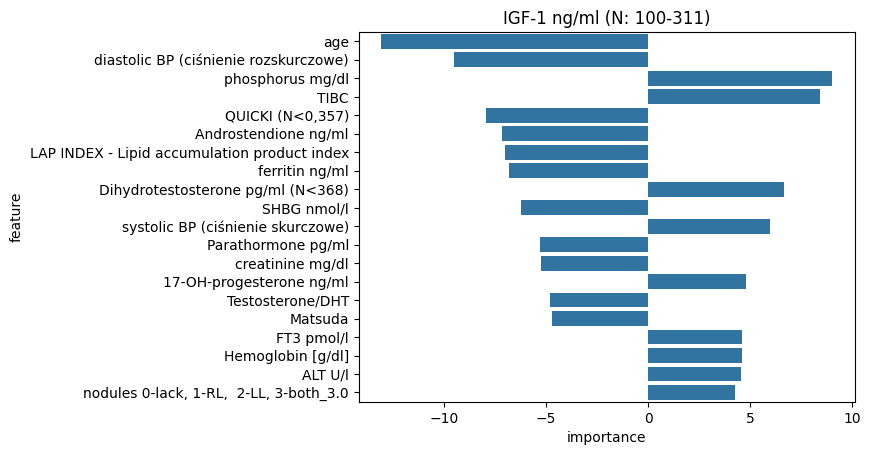

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=200),training,4387.517,50.534,66.238,0.399
1,Ridge(alpha=200),test,6454.237,61.051,80.338,0.068


In [20]:
ridge_model = Ridge(alpha=200)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

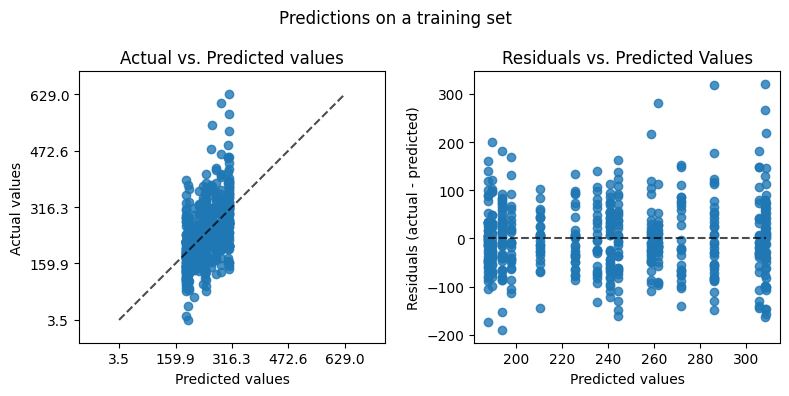

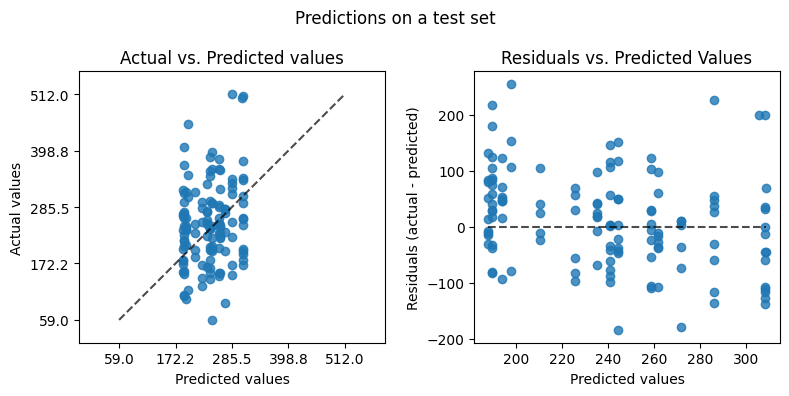

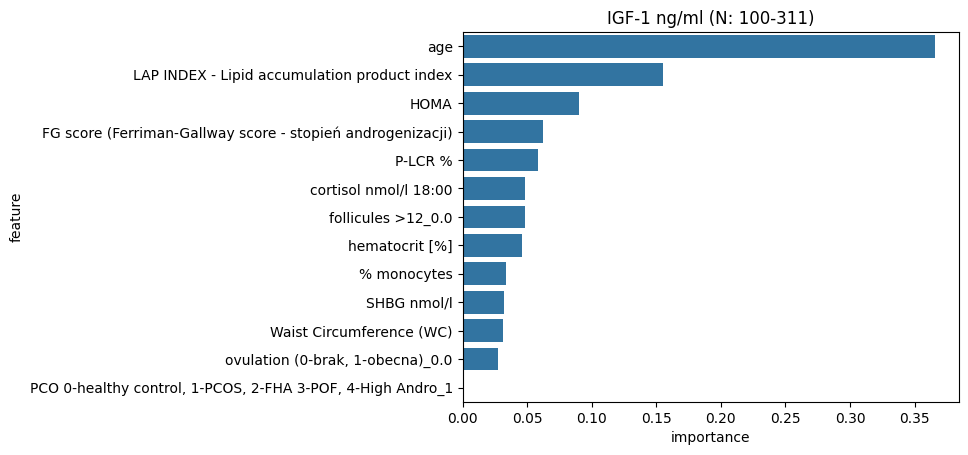

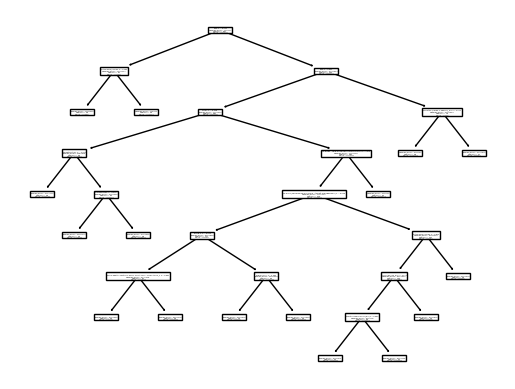

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n random_state=16, splitter='random')",training,5490.743,57.098,74.100,0.248
1,"DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n random_state=16, splitter='random')",test,7355.046,67.500,85.762,-0.062


In [18]:
tree_model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random', random_state=16)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

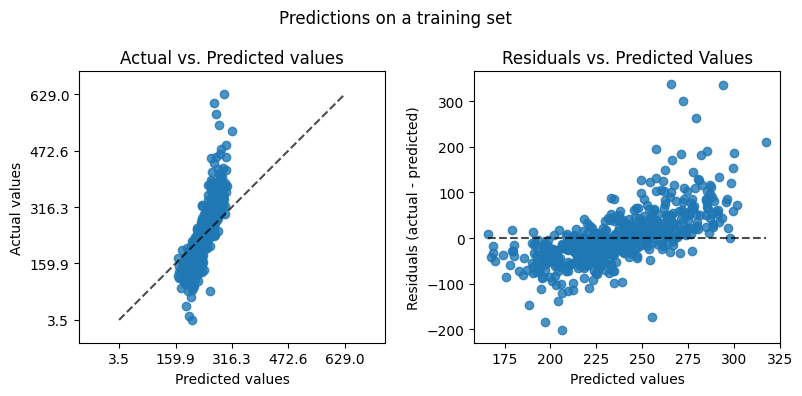

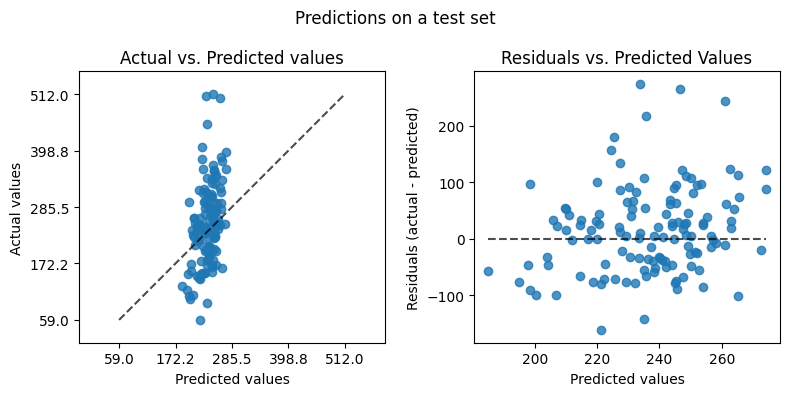

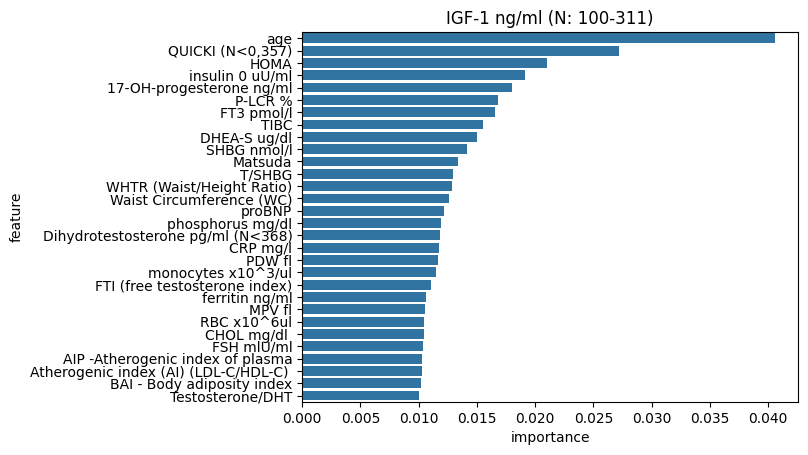

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",training,3963.246,44.633,62.954,0.457
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",test,6222.369,60.065,78.882,0.102


In [30]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df